# Business Problem

## 1.Description

### The automatic generation of medical reports given x-ray images has a significant chance of improving the patients treatment and care. Although there have been instances of using deep learning for detection and classification of medical images,generating the report based on images would be of great help for medical practioners.

### For this case study we propose a new encoder-decoder architecture. In this model we will use deep learning models to extract features and process the data. The experimental results are conducted on the Indiana University Chest -X Ray dataset which is provided to us in the raw format for non commercial use. It has around 7k images and around 3.5k reports.




## 2. Overview of the data
#### Data is provided to us in an xml format. Each xml file contains id of the image, descrption of the condition of the patient , finding and Indication. Below we give a sample screen shot of an sample data point.

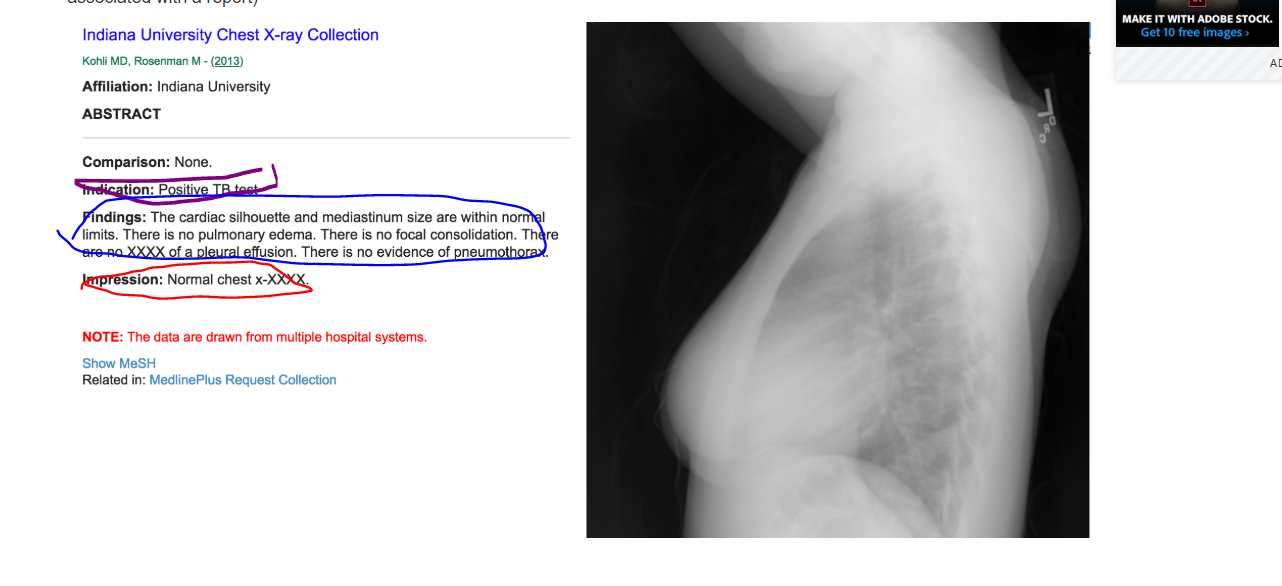

## 3. Performance Metric
     - We will be using Bleu score to match the reports generated with the original report.
     - Training loss will be Sparse Categorical cross Entropy.

## EDA 

In [74]:
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [46]:
columns = ["image_name","image_captions","comparison","indication","findings","impression"]
df = pd.DataFrame(columns=columns)
#list of files in the directory
for file in tqdm(os.listdir("ecgen-radiology/")):
    if file.endswith(".xml"):
        # parsing the  xml files 
        tree = ET.parse("ecgen-radiology/"+file)
        img_list = set()
        caption_list = set()
        # finding all the subelements 
        for parent in tree.findall('parentImage'):
            img = parent.attrib['id'] + ".png"
            caption_list.add(''if parent.find('caption').text is None else parent.find('caption').text)
            img_list.add(img)
        # finds all the 
        comparison = tree.findtext(".//AbstractText[@Label='COMPARISON']")
        indication = tree.findtext(".//AbstractText[@Label='INDICATION']")
        findings   = tree.findtext(".//AbstractText[@Label='FINDINGS']")
        impression = tree.findtext(".//AbstractText[@Label='IMPRESSION']")
        
        # adding reports to the dataframe
        df = df.append(pd.Series([','.join(img_list),','.join(caption_list),comparison,indication,findings,impression],index= columns),ignore_index=True)
        
        
        
            
            
    


    
    

100%|█████████████████████████████████████████████████████████████████████████████| 3955/3955 [00:11<00:00, 336.54it/s]


In [47]:
df.head()

,image_name,image_captions,comparison,indication,findings,impression
0,"CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png",Xray Chest PA and Lateral,None.,Positive TB test,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,"CXR10_IM-0002-1001.png,CXR10_IM-0002-2001.png",PA and lateral chest x-XXXX XXXX.,Chest radiographs XXXX.,"XXXX-year-old male, chest pain.",The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.
2,"CXR100_IM-0002-1001.png,CXR100_IM-0002-2001.png","CHEST 2V FRONTAL/LATERAL XXXX, XXXX XXXX PM",None.,,Both lungs are clear and expanded. Heart and m...,No active disease.
3,"CXR1000_IM-0003-1001.png,CXR1000_IM-0003-3001....",PA and lateral chest x-XXXX XXXX.,XXXX PA and lateral chest radiographs,"XXXX-year-old male, XXXX.",There is XXXX increased opacity within the rig...,1. Increased opacity in the right upper lobe w...
4,"CXR1001_IM-0004-1001.png,CXR1001_IM-0004-1002.png","CHEST 2V FRONTAL/LATERAL XXXX, XXXX XXXX PM",None,"dyspnea, subjective fevers, arthritis, immigra...",Interstitial markings are diffusely prominent ...,Diffuse fibrosis. No visible focal acute disease.


In [49]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [50]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [52]:
def preprocess(data):
    preprocessed_reviews = []
    review_length  = []
    
    for sentance in tqdm(data.values):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        sentance = re.sub(r'XXXX', ' ', sentance)
        sentance = re.sub(r'XXXX XXXX', ' ', sentance)
        sentance = re.sub(r'XXXX-year-old', ' ', sentance)
        
        
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        preprocessed_reviews.append(sentance.strip())
    return preprocessed_reviews
        


    

In [53]:
df['image_captions'] = preprocess(df['image_captions'])

100%|████████████████████████████████████████████████████████████████████████████| 3955/3955 [00:00<00:00, 4421.66it/s]


In [54]:
df['comparison'] = preprocess(df['comparison'])

 39%|█████████████████████████████▉                                              | 1556/3955 [00:00<00:00, 4884.14it/s]C:\Users\user\Anaconda3\envs\tf-gpu\lib\site-packages\bs4\__init__.py:333: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
100%|████████████████████████████████████████████████████████████████████████████| 3955/3955 [00:00<00:00, 4931.77it/s]


In [55]:
df['indication'] = preprocess(df['indication'])

100%|████████████████████████████████████████████████████████████████████████████| 3955/3955 [00:00<00:00, 4432.34it/s]


In [56]:
df['findings'] = preprocess(df['findings'])

100%|████████████████████████████████████████████████████████████████████████████| 3955/3955 [00:01<00:00, 3952.60it/s]


In [57]:
df['impression'] = preprocess(df['impression'])

100%|████████████████████████████████████████████████████████████████████████████| 3955/3955 [00:00<00:00, 4201.51it/s]


In [58]:
df.head()

,image_name,image_captions,comparison,indication,findings,impression
0,"CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png",xray chest pa lateral,none,positive tb test,cardiac silhouette mediastinum size within nor...,normal chest x
1,"CXR10_IM-0002-1001.png,CXR10_IM-0002-2001.png",pa lateral chest x,chest radiographs,year old male chest pain,cardiomediastinal silhouette within normal lim...,no acute cardiopulmonary process
2,"CXR100_IM-0002-1001.png,CXR100_IM-0002-2001.png",chest frontal lateral pm,none,,lungs clear expanded heart mediastinum normal,no active disease
3,"CXR1000_IM-0003-1001.png,CXR1000_IM-0003-3001....",pa lateral chest x,pa lateral chest radiographs,year old male,increased opacity within right upper lobe poss...,increased opacity right upper lobe associated ...
4,"CXR1001_IM-0004-1001.png,CXR1001_IM-0004-1002.png",chest frontal lateral pm,none,dyspnea subjective fevers arthritis immigrant ...,interstitial markings diffusely prominent thro...,diffuse fibrosis no visible focal acute disease


In [61]:
# creating a word count column for findings and impression columns
df['findings_count'] = df['findings'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
df['impressions_count'] = df['impression'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))

In [62]:
df.head()

,image_name,image_captions,comparison,indication,findings,impression,findings_count,impressions_count
0,"CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png",xray chest pa lateral,none,positive tb test,cardiac silhouette mediastinum size within nor...,normal chest x,19,3
1,"CXR10_IM-0002-1001.png,CXR10_IM-0002-2001.png",pa lateral chest x,chest radiographs,year old male chest pain,cardiomediastinal silhouette within normal lim...,no acute cardiopulmonary process,29,4
2,"CXR100_IM-0002-1001.png,CXR100_IM-0002-2001.png",chest frontal lateral pm,none,,lungs clear expanded heart mediastinum normal,no active disease,6,3
3,"CXR1000_IM-0003-1001.png,CXR1000_IM-0003-3001....",pa lateral chest x,pa lateral chest radiographs,year old male,increased opacity within right upper lobe poss...,increased opacity right upper lobe associated ...,38,27
4,"CXR1001_IM-0004-1001.png,CXR1001_IM-0004-1002.png",chest frontal lateral pm,none,dyspnea subjective fevers arthritis immigrant ...,interstitial markings diffusely prominent thro...,diffuse fibrosis no visible focal acute disease,11,7


In [66]:
# number of images per row
df['image_count'] = df['image_name'].astype(str).str.split(',').apply(len)

In [67]:
df.head()

,image_name,image_captions,comparison,indication,findings,impression,findings_count,impressions_count,image_count
0,"CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png",xray chest pa lateral,none,positive tb test,cardiac silhouette mediastinum size within nor...,normal chest x,19,3,2
1,"CXR10_IM-0002-1001.png,CXR10_IM-0002-2001.png",pa lateral chest x,chest radiographs,year old male chest pain,cardiomediastinal silhouette within normal lim...,no acute cardiopulmonary process,29,4,2
2,"CXR100_IM-0002-1001.png,CXR100_IM-0002-2001.png",chest frontal lateral pm,none,,lungs clear expanded heart mediastinum normal,no active disease,6,3,2
3,"CXR1000_IM-0003-1001.png,CXR1000_IM-0003-3001....",pa lateral chest x,pa lateral chest radiographs,year old male,increased opacity within right upper lobe poss...,increased opacity right upper lobe associated ...,38,27,3
4,"CXR1001_IM-0004-1001.png,CXR1001_IM-0004-1002.png",chest frontal lateral pm,none,dyspnea subjective fevers arthritis immigrant ...,interstitial markings diffusely prominent thro...,diffuse fibrosis no visible focal acute disease,11,7,2


In [69]:
df.to_csv('Medical.csv',index=False)

# Most occuring sentences

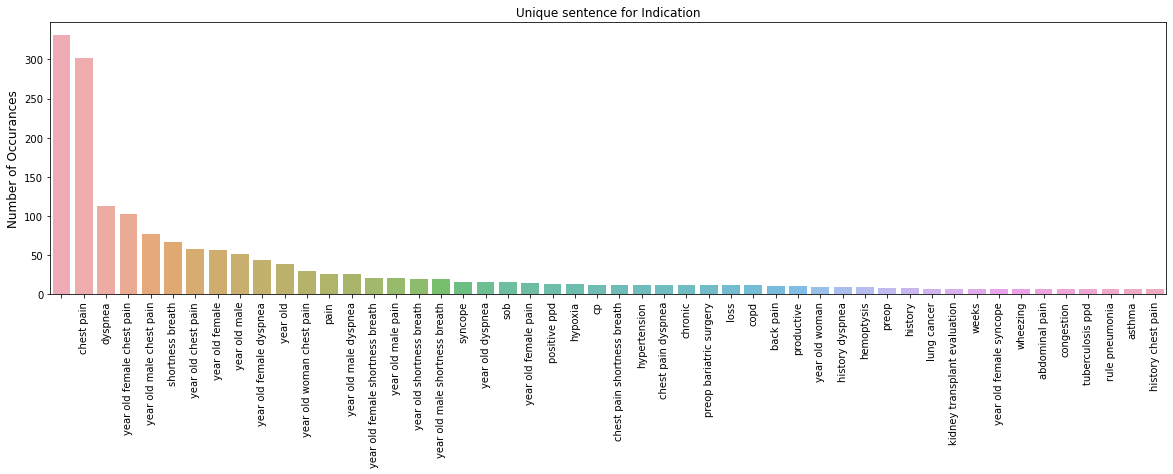

In [70]:
indications = df.indication.value_counts()[0:50]
plt.figure(figsize=(20,5))
sns.barplot(indications.index,indications.values,alpha=0.8)
plt.title("Unique sentence for Indication")
plt.ylabel("Number of Occurances",fontsize=12)
plt.xticks(rotation=90)
plt.show()

#### chest pain in different form seem to be really common indication followed by dyspenea which is a form of breathlessness.

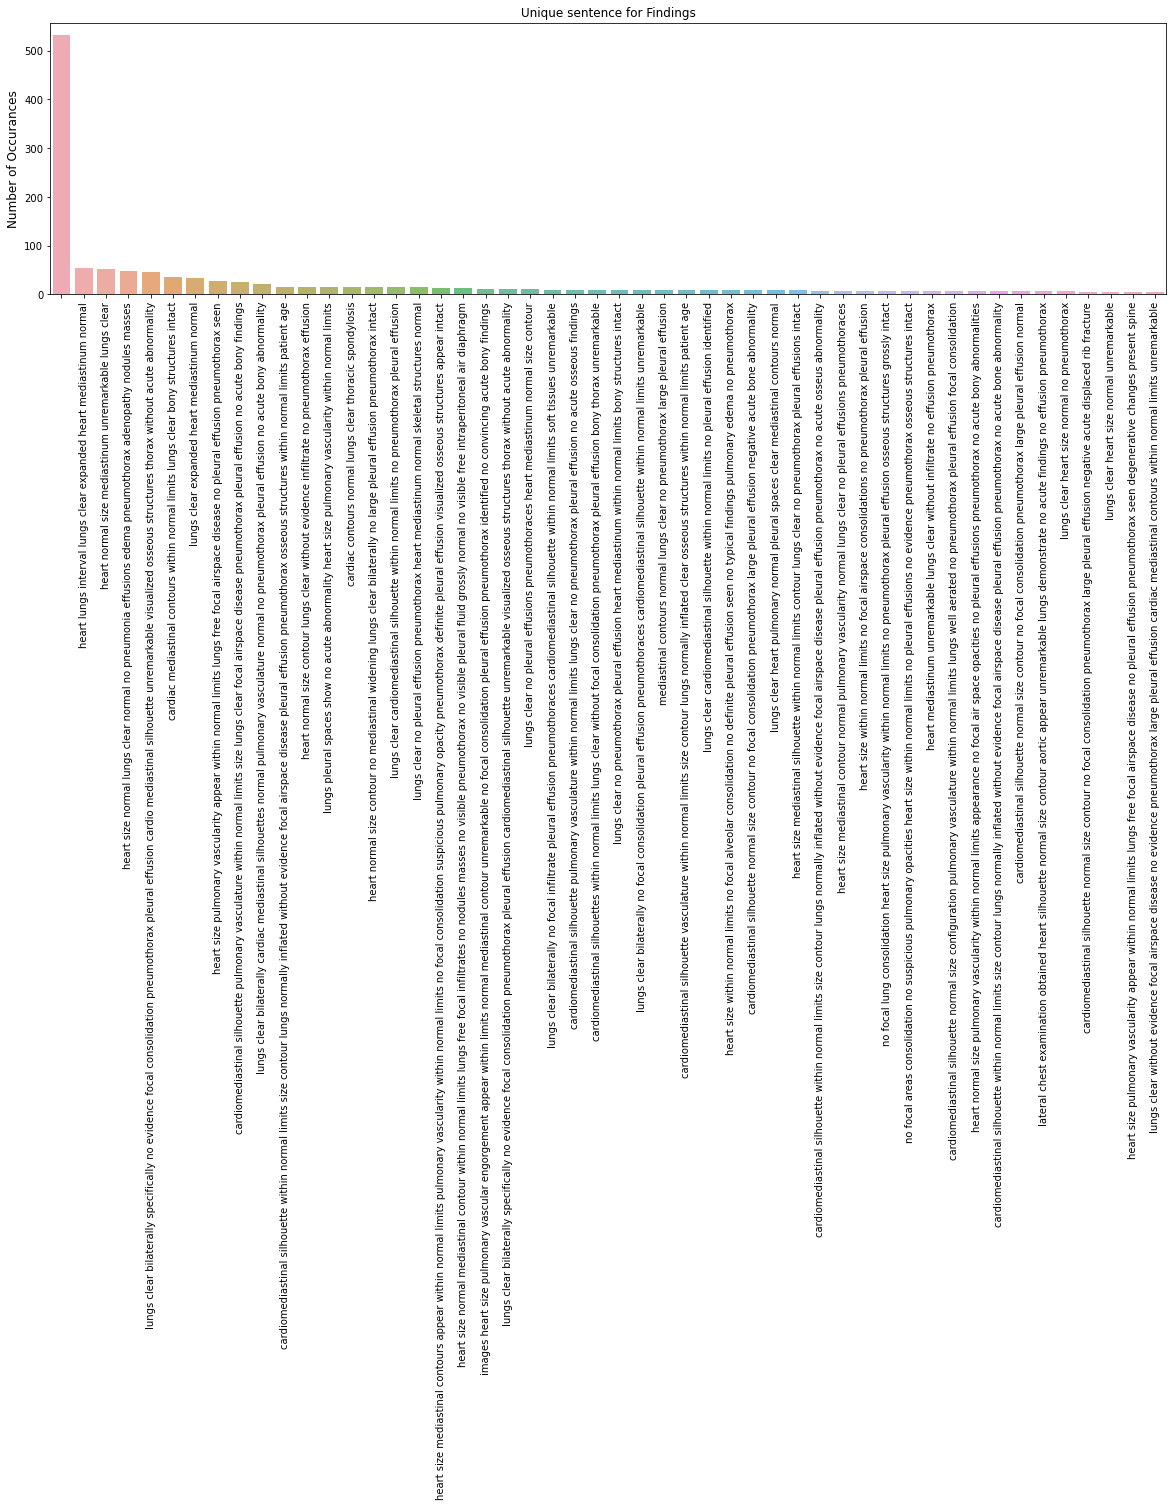

In [71]:
findings = df.findings.value_counts()[0:50]
plt.figure(figsize=(20,5))
sns.barplot(findings.index,findings.values,alpha=0.8)
plt.title("Unique sentence for Findings")
plt.ylabel("Number of Occurances",fontsize=12)
plt.xticks(rotation=90)
plt.show()

### There are more than 500 rows without any findings. The remaining findings occured between 50 to 60 times.

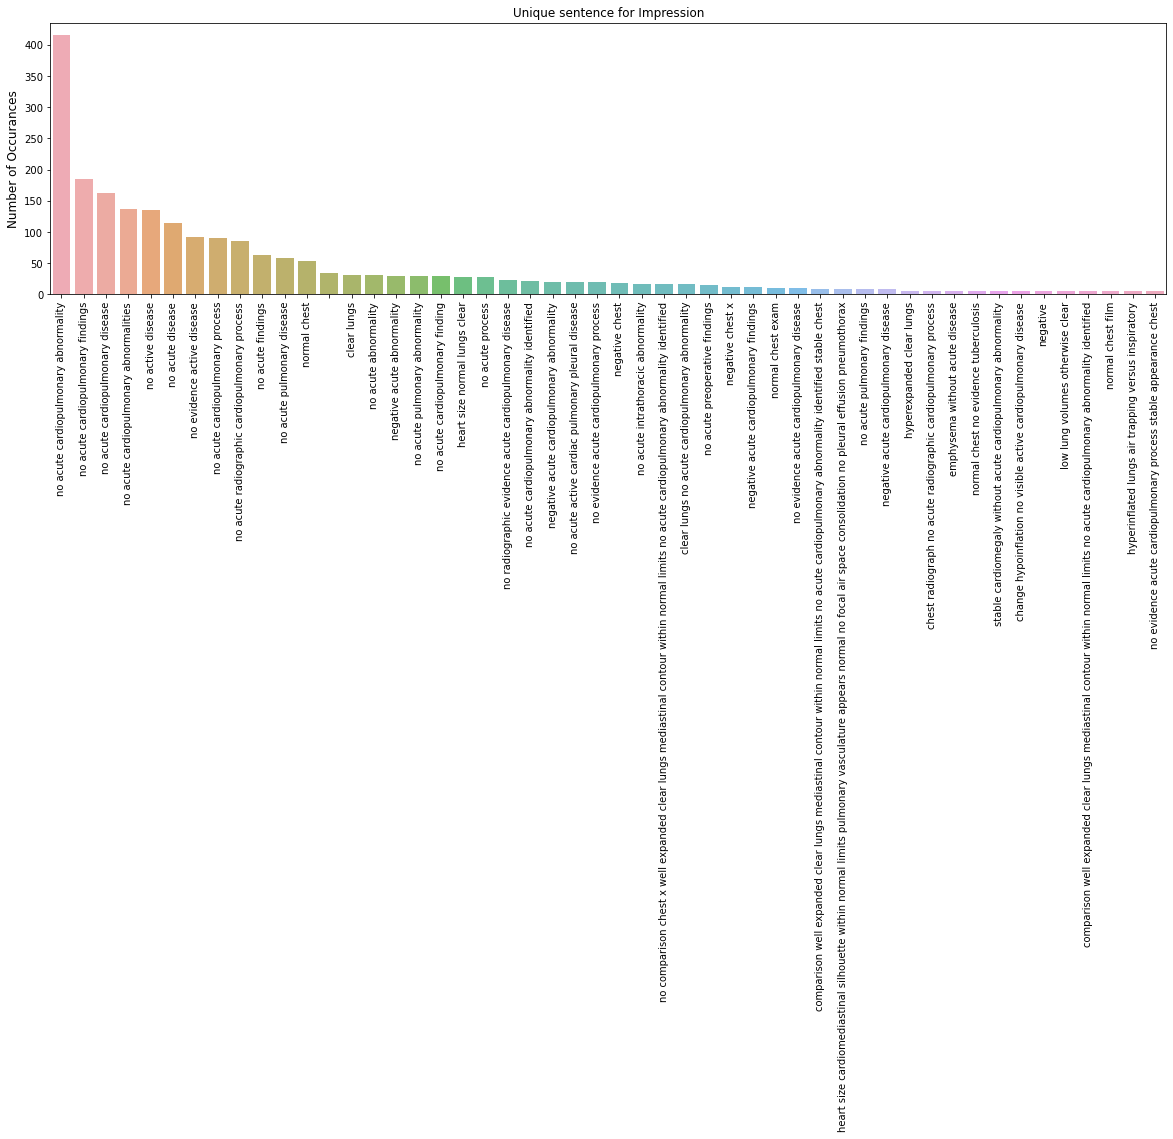

In [72]:
impression = df.impression.value_counts()[0:50]
plt.figure(figsize=(20,5))
sns.barplot(impression.index,impression.values,alpha=0.8)
plt.title("Unique sentence for Impression")
plt.ylabel("Number of Occurances",fontsize=12)
plt.xticks(rotation=90)
plt.show()

### from the above distribution we can see that "No accute cardiopulmanory abnormality" occured 600 times.

# EDA of Images

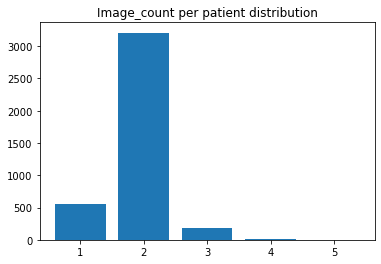

In [73]:
plt.bar(df['image_count'].value_counts().index,df['image_count'].value_counts().values)
plt.title("Image_count per patient distribution")
plt.show()

### The above graph shows clearly that 2 images per patient is the maximum count value.

In [78]:
def patient_record(data):
    for i,row in data.iterrows():
        imgs = row['image_name'].split(",")
        fig,axs = plt.subplots(1,len(imgs),figsize=(10,10),tight_layout=True)
        count = 0
        for img,subplot in zip(imgs,axs.flatten()):
            img_ = mpimg.imread("NLMCXR_png/"+img)
            implot = axs[count].imshow(img_,cmap='bone')
            count += 1
        plt.show()
        
        print("Total Images present for the patient:",len(imgs))
        print("="*100)
        print("Findings:Total number of words{}".format(row['findings_count']))
        print(row['findings'])
        print("="*100)
        print("Impressions:Total number of words{}".format(row['impressions_count']))
        print(row['impression'])
        print("="*100)
        

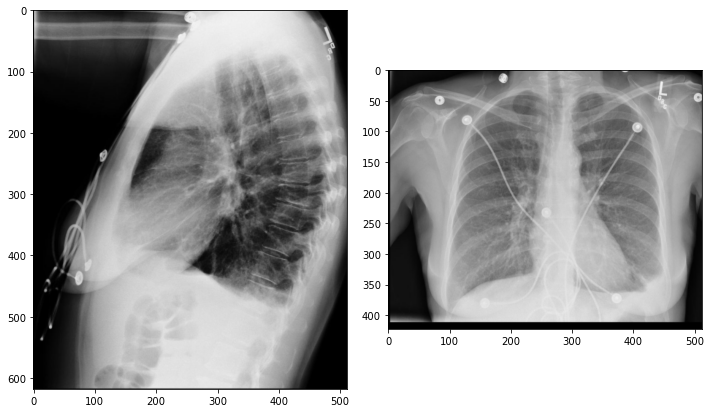

Total Images present for the patient: 2
Findings:Total number of words29
normal cardiomediastinal silhouette interval improvement lung volumes bilaterally improved aeration right left lung bases bilateral small pleural effusions left base atelectatic change interval improvement visualized chest within normal limits
Impressions:Total number of words16
interval improvement aeration lung bases pleural effusions residual small left effusion questionable small right pleural effusion


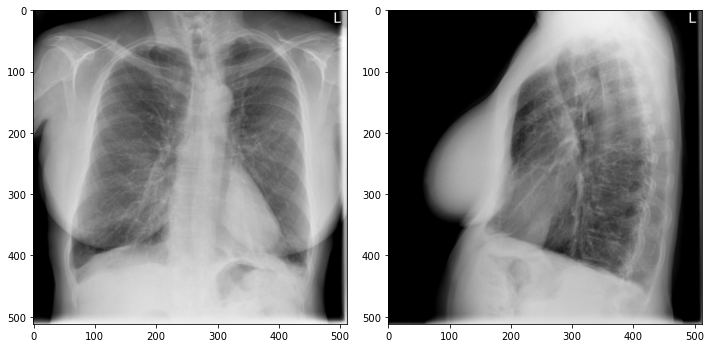

Total Images present for the patient: 2
Findings:Total number of words26
heart size pulmonary vascularity appear within normal limits clearing left base airspace opacities lungs appear clear no pneumothorax pleural effusion seen lungs appear hyperexpanded consistent emphysema
Impressions:Total number of words8
hyperexpanded lungs consistent emphysema no evidence acute disease


In [79]:
patient_record(df[50:52])

## Conclusion
    - All the data was presented to us was in the xml format which we parsed and saved into a dataframe.
    - Each patient has multiple x-ray images, from the data analysis we found out that we have 2 x-ray images per patient is the most common.
    - In the text part we found out that the reports had many unknown values like xxxx which we got rid of by applying some data cleaning.